In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
# from hbmep_paper.simulator import HierarchicalBayesianModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(50, 50, low=0, high=100)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.5))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(mu_a, sigma_a, low=0, high=100)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )

In [3]:
import pickle


root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/tms/hbm-chains.toml")

CONFIG = Config(toml_path=toml_path)
MODEL = HierarchicalBayesianModel(config=CONFIG)

src = "/home/vishu/data/hbmep-processed/human/tms/data.csv"
DF = pd.read_csv(src)

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)



2023-09-21 13:06:59,488 - hbmep.config - INFO - Verifying configuration ...
2023-09-21 13:06:59,488 - hbmep.config - INFO - Success!
2023-09-21 13:06:59,507 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-21 13:06:59,512 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains
2023-09-21 13:06:59,513 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains
2023-09-21 13:06:59,514 - hbmep.dataset.core - INFO - Processing data ...
2023-09-21 13:06:59,515 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [160]:
# df1 = DF[MODEL.combination_columns].drop_duplicates().reset_index(drop=True)
# prefix = "range"

# start_space = [0, 10, 20, 30, 40, 50, 60]
# end = 70
# n_draws = 1

# N = 56
# m = 1
# N_eff = N // m


# # """ Test """
# # start_space = [0, 10, 20]
# # end = 70
# # n_draws = 2
# #
# # N = 3
# # m = 1
# # N_eff = N // m


# dfs = []
# threshold_dfs = []

# for draw_ind in range(n_draws):
#     curr_draw_threshold_true = np.array(POSTERIOR_SAMPLES[site.a][draw_ind, ...])
#     curr_draw_threshold_true = curr_draw_threshold_true[None, ...]

#     threshold_df = df1.copy()
#     threshold_df[MODEL.response] = 0

#     for c in combinations:
#         ind = threshold_df[MODEL.combination_columns[::-1]].apply(tuple, axis=1).isin([tuple(c)])
#         threshold_df.loc[ind, MODEL.response] = curr_draw_threshold_true[0, *c, :]

#     threshold_dfs.append(threshold_df)

#     for start in start_space:
#         logger.info(f"draw:{draw_ind}, start:{start}, end:{end}")
#         draw_dir = f"draw{draw_ind:02}"
#         subdir = f"start{start:02}"

#         df2 = pd.DataFrame(np.linspace(start, end, N_eff), columns=[MODEL.intensity])
#         df = df1.merge(df2, how="cross")
#         df = pd.concat([df] * m, ignore_index=True).reset_index(drop=True)

#         ppd = MODEL.predict(df=df, posterior_samples=POSTERIOR_SAMPLES)
#         df[MODEL.response] = ppd[site.obs][draw_ind, ...]
#         dfs.append(df)


# def _plot(
#     self,
#     df: pd.DataFrame,
#     dfs: list[pd.DataFrame],
#     threshold_df: pd.DataFrame,
#     destination_path: str,
# ):
#     """ Setup pdf layout """
#     combinations = self._make_combinations(df=df, columns=self.combination_columns)
#     n_combinations = len(combinations)

#     n_columns_per_response = 1 + len(dfs)

#     n_fig_rows = 10
#     n_fig_columns = n_columns_per_response * self.n_response

#     n_pdf_pages = n_combinations // n_fig_rows
#     if n_combinations % n_fig_rows: n_pdf_pages += 1
#     logger.info("Rendering ...")

#     """ Iterate over pdf pages """
#     pdf = PdfPages(destination_path)
#     combination_counter = 0

#     for page in range(n_pdf_pages):
#         n_rows_current_page = min(
#             n_fig_rows,
#             n_combinations - page * n_fig_rows
#         )

#         fig, axes = plt.subplots(
#             n_rows_current_page,
#             n_fig_columns,
#             figsize=(
#                 n_fig_columns * self.subplot_cell_width,
#                 n_rows_current_page * self.subplot_cell_height
#             ),
#             constrained_layout=True,
#             squeeze=False
#         )

#         """ Iterate over combinations """
#         for i in range(n_rows_current_page):
#             curr_combination = combinations[combination_counter]

#             """ Filter dataframe based on current combination """
#             df_ind = df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#             curr_df = df[df_ind].reset_index(drop=True).copy()

#             th_ind = threshold_df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#             curr_th_df = threshold_df[th_ind].reset_index(drop=True).copy()
#             curr_ths = curr_th_df[self.response].values[0]

#             """ Iterate over responses """
#             j = 0
#             for r, response in enumerate(self.response):
#                 """ Plots: Scatter Plot """
#                 ax = axes[i, j]
#                 sns.scatterplot(data=curr_df, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)

#                 if j == 1:
#                     ax.legend(loc="upper right")

#                 ax.set_title("Real Data - " + response)

#                 j += 1

#                 for sim_ind, curr_sim in enumerate(dfs):
#                     curr_sim = curr_sim.copy()
#                     curr_sim_ind = curr_sim[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#                     curr_sim = curr_sim[curr_sim_ind].reset_index(drop=True).copy()

#                     ax = axes[i, j]
#                     sns.scatterplot(data=curr_sim, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)
#                     ax.axvline(curr_ths[r], color="black", label="True Threshold")
#                     ax.set_title(f"Simulated Data: Interval ({start_space[sim_ind]}, 70)")

#                     if not sim_ind:
#                         ax.legend(loc="upper right")

#                     j += 1

#             combination_counter += 1

#         pdf.savefig(fig)
#         plt.close()

#     pdf.close()
#     plt.show()

#     logger.info(f"Saved to {destination_path}")
#     return

# dest = os.path.join(MODEL.build_dir, prefix, "comparison.pdf")
# _plot(self=MODEL, df=DF, dfs=dfs, threshold_df=threshold_dfs[0], destination_path=dest)

2023-09-22 13:17:55,286 - __main__ - INFO - Rendering ...


2023-09-22 13:18:11,236 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/comparison.pdf


In [172]:
# ppd = MODEL.predict(df=DF, posterior_samples=POSTERIOR_SAMPLES)
# obs = ppd[site.obs]

# n_draws = 3

# dfs = []
# threshold_dfs = []

# for draw_ind in range(n_draws):
#     df = DF.copy()
#     df[MODEL.response] = obs[draw_ind, ...]
#     dfs.append(df)

#     curr_draw_threshold_true = np.array(POSTERIOR_SAMPLES[site.a][draw_ind, ...])
#     curr_draw_threshold_true = curr_draw_threshold_true[None, ...]

#     threshold_df = df1.copy()
#     threshold_df[MODEL.response] = 0

#     for c in combinations:
#         ind = threshold_df[MODEL.combination_columns[::-1]].apply(tuple, axis=1).isin([tuple(c)])
#         threshold_df.loc[ind, MODEL.response] = curr_draw_threshold_true[0, *c, :]

#     threshold_dfs.append(threshold_df)

# def _plot(
#     self,
#     df: pd.DataFrame,
#     dfs: list[pd.DataFrame],
#     threshold_dfs: list[pd.DataFrame],
#     destination_path: str,
# ):
#     """ Setup pdf layout """
#     combinations = self._make_combinations(df=df, columns=self.combination_columns)
#     n_combinations = len(combinations)

#     n_columns_per_response = 1 + len(dfs)

#     n_fig_rows = 10
#     n_fig_columns = n_columns_per_response * self.n_response

#     n_pdf_pages = n_combinations // n_fig_rows
#     if n_combinations % n_fig_rows: n_pdf_pages += 1
#     logger.info("Rendering ...")

#     """ Iterate over pdf pages """
#     pdf = PdfPages(destination_path)
#     combination_counter = 0

#     for page in range(n_pdf_pages):
#         n_rows_current_page = min(
#             n_fig_rows,
#             n_combinations - page * n_fig_rows
#         )

#         fig, axes = plt.subplots(
#             n_rows_current_page,
#             n_fig_columns,
#             figsize=(
#                 n_fig_columns * self.subplot_cell_width,
#                 n_rows_current_page * self.subplot_cell_height
#             ),
#             constrained_layout=True,
#             squeeze=False
#         )

#         """ Iterate over combinations """
#         for i in range(n_rows_current_page):
#             curr_combination = combinations[combination_counter]

#             """ Filter dataframe based on current combination """
#             df_ind = df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#             curr_df = df[df_ind].reset_index(drop=True).copy()

#             """ Iterate over responses """
#             j = 0
#             for r, response in enumerate(self.response):
#                 """ Plots: Scatter Plot """
#                 ax = axes[i, j]
#                 sns.scatterplot(data=curr_df, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)

#                 if j == 1:
#                     ax.legend(loc="upper right")

#                 ax.set_title("Real Data - " + response)

#                 j += 1

#                 for sim_ind, curr_sim in enumerate(dfs):
#                     curr_sim = curr_sim.copy()
#                     curr_sim_ind = curr_sim[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#                     curr_sim = curr_sim[curr_sim_ind].reset_index(drop=True).copy()

#                     th_df = threshold_dfs[sim_ind].copy()
#                     th_ind = th_df[self.combination_columns].apply(tuple, axis=1).isin([curr_combination])
#                     th_df = th_df[th_ind].reset_index(drop=True).copy()
#                     ths = th_df[self.response].values[0]

#                     ax = axes[i, j]
#                     sns.scatterplot(data=curr_sim, x=self.intensity, y=response, color=self.response_colors[r], ax=ax)
#                     ax.axvline(ths[r], color="black", label="True Threshold")

#                     if not sim_ind:
#                         ax.legend(loc="upper right")

#                     ax.set_title(f"Simulated Data: {sim_ind + 1:02}")

#                     ax.sharex(axes[i, j-1])
#                     ax.sharey(axes[i, j-1])
#                     j += 1

#             combination_counter += 1

#         pdf.savefig(fig)
#         plt.close()

#     pdf.close()
#     plt.show()

#     logger.info(f"Saved to {destination_path}")
#     return

# dest = os.path.join(MODEL.build_dir, prefix, "draws.pdf")
# _plot(self=MODEL, df=DF, dfs=dfs, threshold_dfs=threshold_dfs, destination_path=dest)

2023-09-22 14:34:22,474 - __main__ - INFO - Rendering ...


2023-09-22 14:34:33,073 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draws.pdf


In [5]:
df1 = DF[MODEL.combination_columns].drop_duplicates().reset_index(drop=True)
prefix = "range"

start_space = [0, 10, 20, 30, 40, 50, 60]
end = 70
n_draws = 10

N = 56
m = 1
N_eff = N // m

# """ Test """
# start_space = [0, 10, 20]
# end = 70
# n_draws = 2

# N = 3
# m = 1
# N_eff = N // m

threshold = None
threshold_true = None

for draw_ind in range(n_draws):
    curr_draw_threshold = None

    curr_draw_threshold_true = np.array(POSTERIOR_SAMPLES[site.a][draw_ind, ...])
    curr_draw_threshold_true = curr_draw_threshold_true[None, ...]

    if threshold_true is None:
        threshold_true = curr_draw_threshold_true
    else:
        threshold_true = np.concatenate([threshold_true, curr_draw_threshold_true], axis=0)

    for start in start_space:
        logger.info(f"draw:{draw_ind}, start:{start}, end:{end}")
        draw_dir = f"draw{draw_ind:02}"
        subdir = f"start{start:02}"

        df2 = pd.DataFrame(np.linspace(start, end, N_eff), columns=[MODEL.intensity])
        df = df1.merge(df2, how="cross")
        df = pd.concat([df] * m, ignore_index=True).reset_index(drop=True)

        ppd = MODEL.predict(df=df, posterior_samples=POSTERIOR_SAMPLES)
        df[MODEL.response] = ppd[site.obs][draw_ind, ...]

        """ Build model """
        config = Config(toml_path=toml_path)
        config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, prefix, draw_dir, subdir)
        model = HierarchicalBayesianModel(config=config)
        model._make_dir(dir=model.build_dir)

        """ Fit """
        mcmc, posterior_samples = model.run_inference(df=df)

        """ Predict """
        prediction_df = model.make_prediction_dataset(df=df)
        ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

        """ Plot """
        model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
        model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

        """ Threshold """
        th = np.array(posterior_samples[site.a]).mean(axis=0)
        th = th[None, ...]

        if curr_draw_threshold is None:
            curr_draw_threshold = th
        else:
            curr_draw_threshold = np.concatenate([curr_draw_threshold, th], axis=0)

    curr_draw_threshold = curr_draw_threshold[None, ...]

    if threshold is None:
        threshold = curr_draw_threshold
    else:
        threshold = np.concatenate([threshold, curr_draw_threshold], axis=0)


2023-09-21 13:07:10,315 - __main__ - INFO - draw:0, start:0, end:70
2023-09-21 13:07:13,755 - hbmep.utils.utils - INFO - func:predict took: 3.44 sec
2023-09-21 13:07:13,766 - hbmep.config - INFO - Verifying configuration ...
2023-09-21 13:07:13,766 - hbmep.config - INFO - Success!
2023-09-21 13:07:13,767 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-21 13:07:13,767 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:13:15,872 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 2.11 sec
2023-09-21 13:13:15,878 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:13:21,383 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 13:13:21,406 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:13:27,582 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start00/recruitment_curves.pdf
2023-09-21 13:13:27,583 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.19 sec
2023-09-21 13:13:27,615 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:13:34,948 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start00/posterior_predictive_check.pdf
2023-09-21 13:13:34,950 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.37 sec
2023-09-21 13:13:

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:19:51,144 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 12.94 sec
2023-09-21 13:19:51,148 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:19:56,655 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 13:19:56,679 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:20:02,866 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start10/recruitment_curves.pdf
2023-09-21 13:20:02,867 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.21 sec
2023-09-21 13:20:02,897 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:20:10,438 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start10/posterior_predictive_check.pdf
2023-09-21 13:20:10,439 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.57 sec
2023-09-21 13:20

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:26:35,077 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 21.31 sec
2023-09-21 13:26:35,082 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:26:40,526 - hbmep.utils.utils - INFO - func:predict took: 5.44 sec
2023-09-21 13:26:40,550 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:26:47,478 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start20/recruitment_curves.pdf
2023-09-21 13:26:47,479 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.95 sec
2023-09-21 13:26:47,509 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:26:54,873 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start20/posterior_predictive_check.pdf
2023-09-21 13:26:54,874 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.40 sec
2023-09-21 13:26

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:33:27,277 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 29.06 sec
2023-09-21 13:33:27,282 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:33:32,834 - hbmep.utils.utils - INFO - func:predict took: 5.55 sec
2023-09-21 13:33:32,855 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:33:38,846 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start30/recruitment_curves.pdf
2023-09-21 13:33:38,847 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.01 sec
2023-09-21 13:33:38,877 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:33:45,930 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start30/posterior_predictive_check.pdf
2023-09-21 13:33:45,932 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.08 sec
2023-09-21 13:33

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:40:18,896 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 29.66 sec
2023-09-21 13:40:18,901 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:40:24,485 - hbmep.utils.utils - INFO - func:predict took: 5.58 sec
2023-09-21 13:40:24,507 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:40:30,588 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start40/recruitment_curves.pdf
2023-09-21 13:40:30,589 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.10 sec
2023-09-21 13:40:30,619 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:40:37,580 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start40/posterior_predictive_check.pdf
2023-09-21 13:40:37,581 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 6.99 sec
2023-09-21 13:40

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:47:12,599 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 31.68 sec
2023-09-21 13:47:12,604 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:47:18,084 - hbmep.utils.utils - INFO - func:predict took: 5.48 sec
2023-09-21 13:47:18,107 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:47:24,505 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start50/recruitment_curves.pdf
2023-09-21 13:47:24,505 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.42 sec
2023-09-21 13:47:24,536 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:47:31,435 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start50/posterior_predictive_check.pdf
2023-09-21 13:47:31,437 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 6.93 sec
2023-09-21 13:47

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 13:53:53,644 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 18.40 sec
2023-09-21 13:53:53,649 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 13:53:59,090 - hbmep.utils.utils - INFO - func:predict took: 5.44 sec
2023-09-21 13:53:59,113 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 13:54:05,280 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start60/recruitment_curves.pdf
2023-09-21 13:54:05,281 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.19 sec
2023-09-21 13:54:05,312 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 13:54:12,079 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw00/start60/posterior_predictive_check.pdf
2023-09-21 13:54:12,080 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 6.80 sec
2023-09-21 13:54

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:00:28,960 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 13.54 sec
2023-09-21 14:00:28,965 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:00:34,446 - hbmep.utils.utils - INFO - func:predict took: 5.48 sec
2023-09-21 14:00:34,467 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:00:40,855 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start00/recruitment_curves.pdf
2023-09-21 14:00:40,856 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.40 sec
2023-09-21 14:00:40,886 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:00:48,311 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start00/posterior_predictive_check.pdf
2023-09-21 14:00:48,312 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.46 sec
2023-09-21 14:00

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:07:08,889 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 17.30 sec
2023-09-21 14:07:08,894 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:07:14,398 - hbmep.utils.utils - INFO - func:predict took: 5.50 sec
2023-09-21 14:07:14,420 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:07:20,659 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start10/recruitment_curves.pdf
2023-09-21 14:07:20,660 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.26 sec
2023-09-21 14:07:20,690 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:07:28,542 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start10/posterior_predictive_check.pdf
2023-09-21 14:07:28,544 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.88 sec
2023-09-21 14:07

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:13:46,090 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 14.21 sec
2023-09-21 14:13:46,095 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:13:51,585 - hbmep.utils.utils - INFO - func:predict took: 5.49 sec
2023-09-21 14:13:51,606 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:13:58,133 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start20/recruitment_curves.pdf
2023-09-21 14:13:58,134 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.54 sec
2023-09-21 14:13:58,164 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:14:05,420 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start20/posterior_predictive_check.pdf
2023-09-21 14:14:05,421 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.29 sec
2023-09-21 14:14

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:20:35,635 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 26.89 sec
2023-09-21 14:20:35,640 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:20:41,156 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 14:20:41,177 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:20:47,835 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start30/recruitment_curves.pdf
2023-09-21 14:20:47,836 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.68 sec
2023-09-21 14:20:47,868 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:20:55,086 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start30/posterior_predictive_check.pdf
2023-09-21 14:20:55,087 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.25 sec
2023-09-21 14:20

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:27:29,641 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 31.28 sec
2023-09-21 14:27:29,647 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:27:35,158 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 14:27:35,178 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:27:41,491 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start40/recruitment_curves.pdf
2023-09-21 14:27:41,492 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.33 sec
2023-09-21 14:27:41,523 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:27:48,752 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start40/posterior_predictive_check.pdf
2023-09-21 14:27:48,753 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.26 sec
2023-09-21 14:27

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:34:21,720 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 29.62 sec
2023-09-21 14:34:21,725 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:34:27,282 - hbmep.utils.utils - INFO - func:predict took: 5.56 sec
2023-09-21 14:34:27,303 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:34:33,511 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start50/recruitment_curves.pdf
2023-09-21 14:34:33,511 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.22 sec
2023-09-21 14:34:33,541 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:34:40,510 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start50/posterior_predictive_check.pdf
2023-09-21 14:34:40,511 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.00 sec
2023-09-21 14:34

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:41:01,277 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 17.46 sec
2023-09-21 14:41:01,281 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:41:06,793 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 14:41:06,813 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:41:13,285 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start60/recruitment_curves.pdf
2023-09-21 14:41:13,286 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.49 sec
2023-09-21 14:41:13,316 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:41:20,363 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw01/start60/posterior_predictive_check.pdf
2023-09-21 14:41:20,364 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.08 sec
2023-09-21 14:41

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:47:34,286 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 10.64 sec
2023-09-21 14:47:34,291 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:47:39,869 - hbmep.utils.utils - INFO - func:predict took: 5.58 sec
2023-09-21 14:47:39,890 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:47:46,278 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start00/recruitment_curves.pdf
2023-09-21 14:47:46,279 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.40 sec
2023-09-21 14:47:46,310 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:47:53,855 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start00/posterior_predictive_check.pdf
2023-09-21 14:47:53,856 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.58 sec
2023-09-21 14:47

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 14:54:07,809 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 10.65 sec
2023-09-21 14:54:07,814 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 14:54:13,325 - hbmep.utils.utils - INFO - func:predict took: 5.51 sec
2023-09-21 14:54:13,347 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 14:54:19,746 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start10/recruitment_curves.pdf
2023-09-21 14:54:19,747 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.42 sec
2023-09-21 14:54:19,777 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 14:54:27,428 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start10/posterior_predictive_check.pdf
2023-09-21 14:54:27,430 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.68 sec
2023-09-21 14:54

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:00:48,472 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 17.68 sec
2023-09-21 15:00:48,476 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:00:53,947 - hbmep.utils.utils - INFO - func:predict took: 5.47 sec
2023-09-21 15:00:53,967 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:01:00,612 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start20/recruitment_curves.pdf
2023-09-21 15:01:00,612 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.66 sec
2023-09-21 15:01:00,644 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:01:08,305 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start20/posterior_predictive_check.pdf
2023-09-21 15:01:08,306 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.69 sec
2023-09-21 15:01

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:07:41,233 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 29.58 sec
2023-09-21 15:07:41,238 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:07:46,765 - hbmep.utils.utils - INFO - func:predict took: 5.53 sec
2023-09-21 15:07:46,785 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:07:53,125 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start30/recruitment_curves.pdf
2023-09-21 15:07:53,126 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.36 sec
2023-09-21 15:07:53,159 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:08:00,699 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start30/posterior_predictive_check.pdf
2023-09-21 15:08:00,700 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.57 sec
2023-09-21 15:08

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:14:36,800 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 32.78 sec
2023-09-21 15:14:36,805 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:14:42,342 - hbmep.utils.utils - INFO - func:predict took: 5.54 sec
2023-09-21 15:14:42,363 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:14:49,283 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start40/recruitment_curves.pdf
2023-09-21 15:14:49,284 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.94 sec
2023-09-21 15:14:49,314 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:14:56,805 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start40/posterior_predictive_check.pdf
2023-09-21 15:14:56,806 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.52 sec
2023-09-21 15:14

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:21:27,014 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 26.89 sec
2023-09-21 15:21:27,019 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:21:32,662 - hbmep.utils.utils - INFO - func:predict took: 5.64 sec
2023-09-21 15:21:32,682 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:21:39,333 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start50/recruitment_curves.pdf
2023-09-21 15:21:39,334 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.67 sec
2023-09-21 15:21:39,364 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:21:46,703 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start50/posterior_predictive_check.pdf
2023-09-21 15:21:46,705 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.37 sec
2023-09-21 15:21

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:28:09,039 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 19.05 sec
2023-09-21 15:28:09,044 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:28:14,533 - hbmep.utils.utils - INFO - func:predict took: 5.49 sec
2023-09-21 15:28:14,553 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:28:21,023 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start60/recruitment_curves.pdf
2023-09-21 15:28:21,024 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.49 sec
2023-09-21 15:28:21,054 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:28:28,381 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw02/start60/posterior_predictive_check.pdf
2023-09-21 15:28:28,383 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.36 sec
2023-09-21 15:28

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:34:43,687 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 11.96 sec
2023-09-21 15:34:43,692 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:34:49,161 - hbmep.utils.utils - INFO - func:predict took: 5.47 sec
2023-09-21 15:34:49,180 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:34:56,062 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start00/recruitment_curves.pdf
2023-09-21 15:34:56,063 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.90 sec
2023-09-21 15:34:56,094 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:35:04,029 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start00/posterior_predictive_check.pdf
2023-09-21 15:35:04,030 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.97 sec
2023-09-21 15:35

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:41:19,509 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 12.18 sec
2023-09-21 15:41:19,514 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:41:25,007 - hbmep.utils.utils - INFO - func:predict took: 5.49 sec
2023-09-21 15:41:25,027 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:41:31,775 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start10/recruitment_curves.pdf
2023-09-21 15:41:31,776 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.76 sec
2023-09-21 15:41:31,807 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:41:38,929 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start10/posterior_predictive_check.pdf
2023-09-21 15:41:38,930 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.15 sec
2023-09-21 15:41

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:48:05,675 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 22.50 sec
2023-09-21 15:48:05,680 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:48:11,222 - hbmep.utils.utils - INFO - func:predict took: 5.54 sec
2023-09-21 15:48:11,241 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:48:18,721 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start20/recruitment_curves.pdf
2023-09-21 15:48:18,722 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.50 sec
2023-09-21 15:48:18,753 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:48:25,724 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start20/posterior_predictive_check.pdf
2023-09-21 15:48:25,725 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.00 sec
2023-09-21 15:48

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 15:54:57,098 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 28.06 sec
2023-09-21 15:54:57,103 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 15:55:02,630 - hbmep.utils.utils - INFO - func:predict took: 5.53 sec
2023-09-21 15:55:02,650 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 15:55:09,023 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start30/recruitment_curves.pdf
2023-09-21 15:55:09,024 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.39 sec
2023-09-21 15:55:09,054 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 15:55:15,904 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start30/posterior_predictive_check.pdf
2023-09-21 15:55:15,906 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 6.88 sec
2023-09-21 15:55

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 16:01:49,999 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 30.77 sec
2023-09-21 16:01:50,004 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 16:01:55,526 - hbmep.utils.utils - INFO - func:predict took: 5.52 sec
2023-09-21 16:01:55,546 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 16:02:01,936 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start40/recruitment_curves.pdf
2023-09-21 16:02:01,937 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.41 sec
2023-09-21 16:02:01,969 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 16:02:10,117 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start40/posterior_predictive_check.pdf
2023-09-21 16:02:10,119 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 8.18 sec
2023-09-21 16:02

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-21 16:08:46,268 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 32.73 sec
2023-09-21 16:08:46,273 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-09-21 16:08:51,843 - hbmep.utils.utils - INFO - func:predict took: 5.57 sec
2023-09-21 16:08:51,864 - hbmep.model.baseline - INFO - Rendering ...
2023-09-21 16:08:57,695 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start50/recruitment_curves.pdf
2023-09-21 16:08:57,696 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 5.85 sec
2023-09-21 16:08:57,727 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-21 16:09:05,405 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/hbm-chains/range/draw03/start50/posterior_predictive_check.pdf
2023-09-21 16:09:05,406 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 7.71 sec
2023-09-21 16:09

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [75]:
threshold_true.shape

(10, 6, 2, 6)

In [76]:
threshold.shape

(10, 7, 6, 2, 6)

In [121]:
dest = os.path.join(MODEL.build_dir, prefix, "threshold.npy")
np.save(dest, threshold)

dest = os.path.join(MODEL.build_dir, prefix, "threshold_true.npy")
np.save(dest, threshold_true)

In [122]:
src = os.path.join(MODEL.build_dir, prefix, "threshold.npy")
th_ = np.load(src)

(th_ == threshold).all()

True

In [123]:
src = os.path.join(MODEL.build_dir, prefix, "threshold_true.npy")
th_true = np.load(src)

(th_true == threshold_true).all()

True

In [98]:
y = threshold
y_true = threshold_true

print(y.shape, y_true.shape)

(10, 7, 6, 2, 6) (10, 6, 2, 6)


In [99]:
a = POSTERIOR_SAMPLES[site.a].mean(axis=0)
print(a.shape)

combinations = MODEL._make_combinations(df=DF, columns=MODEL.combination_columns)
combinations = [list(c[::-1]) for c in combinations]

y_mask = np.full(y.shape, True)
y_mask[:, :, *map(list, zip(*combinations)), :] = False
print(y_mask.shape)

y_true_mask = np.full(y_true.shape, True)
y_true_mask[:, *map(list, zip(*combinations)), :] = False
print(y_true_mask.shape)

(6, 2, 6)
(10, 7, 6, 2, 6)
(10, 6, 2, 6)


In [100]:
for i in range(10):
    for j in range(5):
            assert (~y_mask[i, j, ...]).sum() == len(combinations) * MODEL.n_response
            assert (y_mask[i, j, ...] == y_mask[0, 0, ...]).all()

for i in range(10):
    assert (~y_true_mask[i, ...]).sum() == len(combinations) * MODEL.n_response
    assert (y_true_mask[i, ...] == y_true_mask[0, ...]).all()

In [101]:
# Additional masks
additional_masks = [
    (2, 1, 0),
    (1, 1, 1),
    (0, 1, 2),
    (1, 1, 2),
    (2, 1, 2),
    (4, 1, 2),
    (3, 1, 2),
    (1, 1, 3),
    (1, 1, 4),
    (0, 1, 5),
    (4, 1, 5)
]

y_mask[:, :, *map(list, zip(*additional_masks))] = True
y_true_mask[:, *map(list, zip(*additional_masks))] = True

In [102]:
y = np.ma.array(y, mask=y_mask)
y_true = np.ma.array(y_true, mask=y_true_mask)

print(y.shape, y_true.shape)

(10, 7, 6, 2, 6) (10, 6, 2, 6)


In [103]:
mae = np.ma.abs(y - y_true[:, None, ...])
mae.shape

(10, 7, 6, 2, 6)

In [104]:
mae[0, ...].shape

(7, 6, 2, 6)

In [105]:
mae[0, ...].mean(axis=-1).shape

(7, 6, 2)

In [106]:
mae[0, ...].mean(axis=-1).std(axis=(-1, -2)).shape

(7,)

In [107]:
mae.shape

(10, 7, 6, 2, 6)

In [87]:
mae.shape

(10, 7, 6, 2, 6)

In [88]:
mae[0, ...].mean(axis=-1).mean(axis=(-1, -2)).shape

(7,)

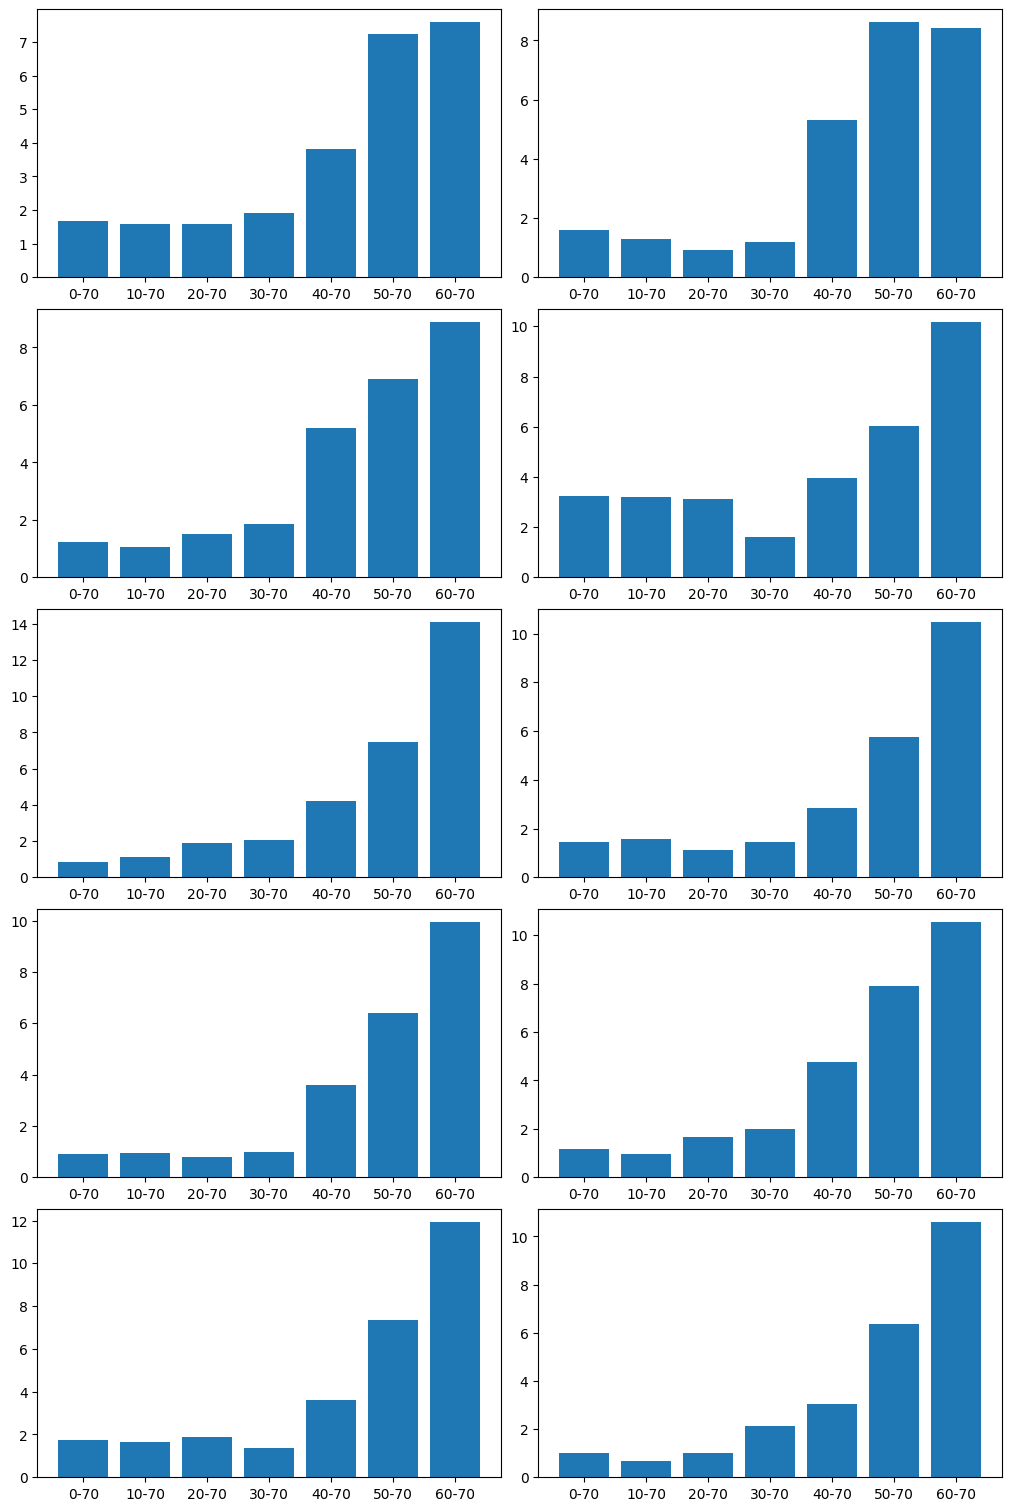

In [108]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True, squeeze=False)

counter = 0
for draw_ind in range(n_draws):
    ax = axes[counter // ncols, counter % ncols]
    ax.bar(x=[elem + "-70" for elem in list(map(str, start_space))], height=mae[draw_ind, ...].mean(axis=-1).mean(axis=(-1, -2)))
    counter += 1

In [109]:
mae.mean(axis=0).mean(axis=-1).shape

(7, 6, 2)

In [110]:
stats.sem(mae.mean(axis=0).mean(axis=-1), axis=(-1, -2))

array([0.57920046, 0.54387104, 0.66772833, 0.63467714, 0.86881641,
       0.72386881, 1.24095576])

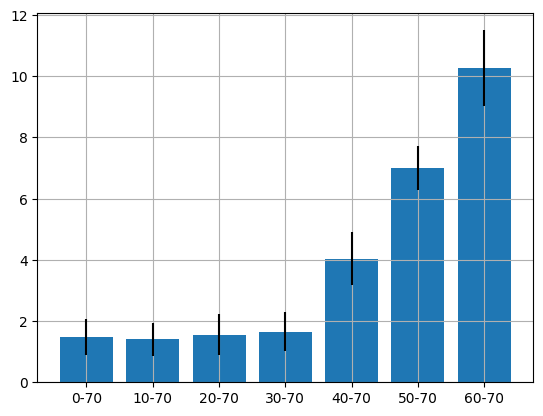

In [111]:
curr_mae = mae.mean(axis=0).mean(axis=-1)

me = curr_mae.mean(axis=(-1, -2))
sem = stats.sem(curr_mae, axis=(-1, -2))

plt.bar(x=[elem + "-70" for elem in list(map(str, start_space))], height=me, yerr=sem)
plt.grid()

Text(0.5, -0.3, '6 Participants, 6 Muscles, 10 Experiments\n\nH0: (0-70) = (30-70) vs H1 (0-70) < (30-70)\np-value$(df = 5)$: 0.25')

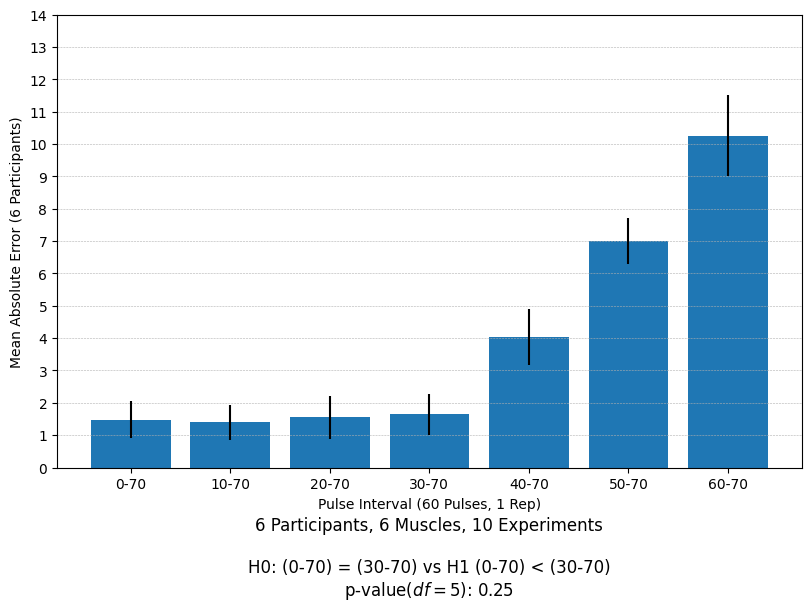

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

curr_mae = mae.mean(axis=0).mean(axis=-1)

me = curr_mae.mean(axis=(-1, -2))
sem = stats.sem(curr_mae, axis=(-1, -2))

ax.bar(x=[elem + "-70" for elem in list(map(str, start_space))], height=me, yerr=sem)
ax.grid(axis="y", linestyle='--', linewidth=.4)
ax.set_yticks(np.arange(0, 15, 1))
ax.set_xlabel("Pulse Interval (60 Pulses, 1 Rep)")
ax.set_ylabel("Mean Absolute Error (6 Participants)")
ax.set_title(
    f'6 Participants, 6 Muscles, 10 Experiments\n\nH0: (0-70) = (30-70) vs H1 (0-70) < (30-70)\np-value$(df = 5)$: 0.25',
    y=-0.3
)


In [113]:
labs = [elem + "-70" for elem in list(map(str, start_space))]

In [114]:
curr_mae = mae.mean(axis=0).mean(axis=-1)

compare_ind = 3
t = (curr_mae[compare_ind, ...] - curr_mae[0, ...])
t = t.reshape(t.shape[0], -1)
t.shape

p = stats.ttest_1samp(t[t.mask == False].data, popmean=0, alternative="greater").pvalue
print(labs[compare_ind], " vs ", labs[0])
print(f"p-value (one-sided): {p:.2f}")

30-70  vs  0-70
p-value (one-sided): 0.25
